# Clinical Trial Navigator

This program is a tool to query the ClinicalTrials.gov database, build a formatted data table of clinical trials based on custom search criteria.  The data table will contain details on clinical trial design, protocol, indication, product, start/completion date, and outcome measures.  Outcome measures are specifically broken out in detail to allow for more in-depth analyses.

Users can then search across a data table containing all primary and secondary endpoints used in all clinical trials returned in the study data table, to identify how many studies reported a specific endpoint.

This database file can also be used to conduct detailed analyses, i.e. compare trial duration, sample size, primary / secondary endpoints, and outcome measure performance for all phase 3 trials in a specific indication or drug class.

I took a hybrid object-oriented / functional approach for the Clinical Trial Navigator tool.

I designed a Query class to draft a query URL that will be used to search the ClinicalTrials.gov API.  I pre-selected a list of field names I found to be of greatest interest (the API allows up to 25 field values per query), and the full list of field names can be found at https://clinicaltrials.gov/api/info/study_structure. The list of field values included in the query can be modified as needed on an ad-hoc basis.  

The Query class then converts the JSON query result to a pandas dataframe to allow for easier analysis.

The Study class represents individual clinical studies, and will be used to extract the various clinical trial criteria (i.e. all primary + secondary endpoints) from the individual studies to allow for more detailed analyses.

I built several functions to clean, format, search and analyze the data returned from each query and study.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import time
from textwrap import wrap

#import nltk                                        # previous version of this project tried to leverage the NLTK package, but I decided against it for now
#from nltk.tokenize import word_tokenize

#nltk.download('punkt')
    
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', 100)

In [2]:
class Query:        # class to create a query from the clinicaltrials API that will house the list of clinical trials returned from the API, with detailed information for each
    
    def __init__(self, name = 'Query_1'):
        self.name = name
        self.study_tracker = []         # build list that tracks which studies have been built via build_study within the query

    def build_query(self):
        self.query_terms = input('\n\nEnter the search query term: \n\n')           # input search terms used to query the clinicaltrials.gov API - tokenize into a list of search terms
        
        print('\n\nSearch Term: \n\n'+self.query_terms+'\n\n')
        
        query_tokenized = self.query_terms.split()
        
        field_values = ['NCTId', 'BriefTitle', 'Condition', 'Phase', 'StudyType',
                        'EnrollmentCount', 'StartDate', 'PrimaryCompletionDate', 'EligibilityCriteria', 'InterventionName', 
                        'ArmGroupInterventionName', 'ArmGroupDescription', 'InterventionArmGroupLabel', 'OutcomeMeasureType', 'OutcomeMeasureTitle',
                        'OutcomeMeasureDescription', 'OutcomeMeasureTimeFrame', 'OutcomeMeasurementValue', 'OutcomeMeasureUnitOfMeasure']
        
        max_rank = 1000             # max # of items returned by the API query (max for the clinicaltrials.gov API is 1000)
        
        
        url = 'https://clinicaltrials.gov/api/query/study_fields?expr='
        
        for i, word in enumerate(query_tokenized):              # build query URL by adding all search terms and field values to the query URL, following the appropriate format
            if i == 0:
                url = url + word
            else:
                url = url + '+' + word
            
        url = url + '&fields='
        
        for i, word in enumerate(field_values):
            if i == 0:
                url = url + word
            else:
                url = url + '%2C' + word
        
        url = url + '&min_rnk=1&max_rnk=' + str(max_rank) + '&fmt=json' 
        url = url.strip()
        self.url = url
        
        print('\n\nQuerying up to 1,000 trials from clinicaltrials.gov with the following url...\n\n'+url+'\n\n')
        
        return self.url
        
    def build_study_table(self, url):
          
        ## convert the clinicaltrials.gov JSON response to a pandas dataframe
        
        result = requests.get(url).json()
        result_list = [result for result in result['StudyFieldsResponse']['StudyFields'] if result['OutcomeMeasureType']]     #loop through the list and identify ONLY studies with outcome measures reported 
        df_master = json_normalize(result_list[0])      # initialize dataframe using JSON result

        try:
            for study in result_list[1:]:        # concatenate each study to the dataframe to generate master dataframe
                df = json_normalize(study)
                df_master = pd.concat([df_master, df], axis=0, ignore_index=True)
        except:
            pass
                                                                    # extract list entries, reformat data in these columns as strings
        try:                                            
            df_master['NCTId'] = [df_master['NCTId'][i][0] for i in range(len(df_master['NCTId'])) if len(df_master['NCTId'][i]) > 0]
        except:
            pass        
        try:
            df_master['BriefTitle'] = [df_master['BriefTitle'][i][0] for i in range(len(df_master['BriefTitle'])) if len(df_master['BriefTitle'][i]) > 0]
        except:
            pass       
        try:
            df_master['Condition'] = [df_master['Condition'][i][0] for i in range(len(df_master['Condition'])) if len(df_master['Condition'][i]) > 0]
        except:
            pass
        try:
            df_master['StudyType'] = [df_master['StudyType'][i][0] for i in range(len(df_master['StudyType'])) if len(df_master['StudyType'][i]) > 0]
        except:
            pass
        
        
        for i in range(len(df_master['Phase'])):                    # extract clinical trial phase(s)
            if df_master['Phase'][i]:
                if len(df_master['Phase'][i]) > 1:
                    df_master['Phase'][i] = df_master['Phase'][i][0] + ', ' + df_master['Phase'][i][1]
                else:
                    df_master['Phase'][i] = df_master['Phase'][i][0]
            else:
                df_master['Phase'][i] = 'Unknown'
        
        
        try:
            df_master['EnrollmentCount'] = [df_master['EnrollmentCount'][i][0] for i in range(len(df_master['EnrollmentCount'])) if len(df_master['EnrollmentCount'][i]) > 0]
        except:
            pass
        try:
            df_master['StartDate'] = [df_master['StartDate'][i][0] for i in range(len(df_master['StartDate'])) if len(df_master['StartDate'][i]) > 0]
        except:
            pass
        try:
            df_master['PrimaryCompletionDate'] = [df_master['PrimaryCompletionDate'][i][0] for i in range(len(df_master['PrimaryCompletionDate'])) if len(df_master['PrimaryCompletionDate'][i]) > 0]
        except:
            pass
        try:
            df_master['EligibilityCriteria'] = [df_master['EligibilityCriteria'][i][0] for i in range(len(df_master['EligibilityCriteria'])) if len(df_master['EligibilityCriteria'][i]) > 0]
        except:
            pass
        
        #df_master['StartDate'] = pd.to_datetime(df_master['StartDate'])
        #df_master['PrimaryCompletionDate'] = pd.to_datetime(df_master['PrimaryCompletionDate'])            # future version of this project will convert starting / ending date to datetime format, to calculate/analyze trial duration
        
        self.df_master = df_master
        
        return self.df_master
    
    def build_outcome_table(self):
        
        # initialize an outcomes_df from the first study within the query study table
        
        query_df_master = self.get_df_master()
        query_df_master = query_df_master[query_df_master['Phase'].str.match('.*3.*', na=False)].reset_index()          # filter ONLY phase 3 studies, which represent pivotal efficacy/safety trials used by the FDA when evaluating a new product 
        study_1 = Study(self, query_df_master['NCTId'][0])
        
        outcomes_df = study_1.extract_outcomes()
        
        study_x = Study(self, query_df_master['NCTId'][1])
        df = study_x.extract_outcomes()
        outcomes_df = pd.concat([outcomes_df, df], axis=0, ignore_index=False)
        
        for i in range(1, len(query_df_master)):                         # concatenate each study to the dataframe to generate master dataframe
            study_x = Study(self, query_df_master['NCTId'][i])
            df = study_x.extract_outcomes()
            outcomes_df = pd.concat([outcomes_df, df], axis=0, ignore_index=False)
        
        outcomes_df = outcomes_df.reset_index().drop(columns='index')
        
        return outcomes_df

    
    def get_url(self):
        return self.url

    def get_study_tracker(self):
        return self.study_tracker
    
    def get_df_master(self):
        if len(self.df_master)>0:
            return self.df_master
        else:
            return 'No df_master exists!'

In [3]:
class Study:
    
    def __init__(self, query, nct_id):                  # all studies are initialized within a query, and are identified via their unique NCT ID (created by clinicaltrials.gov)s
        
        self.nct_id = nct_id
        self.entry = query.get_df_master()[query.get_df_master()['NCTId']==nct_id].reset_index().drop(columns='index')      #build a unique df entry for this NCT ID
        self.df_outcomes = pd.DataFrame(columns=self.entry.columns)
        
        try:                            # identify the number of outcome measure values reported per outcome measure (i.e., measure at baseline, change at week N, P value, etc.)
            self.measures_per_outcome = len(self.entry['OutcomeMeasurementValue'][0])//len(self.entry['OutcomeMeasureTitle'][0])
        except:
            self.measures_per_outcome = 1
        
        if self.nct_id not in query.study_tracker:              #add the study to the query's study tracker
            query.study_tracker.append(self.nct_id)
        
    def get_entry(self):
        return self.entry
    
    def get_indication(self):
        return [item for item in self.entry['Condition']][0]     # returns the first list item within the list of indications

    def extract_outcomes(self):            #iterate thru all outcome measures, create a dataframe with all required info
        
        try:
            self.df_outcomes = self.df_outcomes.drop(columns=['Rank', 'Condition', 'StudyType', 'EnrollmentCount', 'StartDate', 'PrimaryCompletionDate', 'EligibilityCriteria', 'ArmGroupDescription'])
        except:
            pass
        
        for i, item in enumerate(self.entry['OutcomeMeasureType']):
                
            try:
                self.df_outcomes['OutcomeMeasureType'] = [item for item in self.entry['OutcomeMeasureType']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureTitle'] = [item for item in self.entry['OutcomeMeasureTitle']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureDescription'] = [item for item in self.entry['OutcomeMeasureDescription']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureTimeFrame'] = [item for item in self.entry['OutcomeMeasureTimeFrame']][0]
            except:
                pass
            try:
                self.df_outcomes['OutcomeMeasureUnitOfMeasure'] = [item for item in self.entry['OutcomeMeasureUnitOfMeasure']][0]
            except:
                pass

        beginning = 0
        increment = self.measures_per_outcome               # maps correct number of outcome measures reported in the study, as multiple performance values may pertain to each endpoint (i.e. value for each intervention arm + placebo)
       
        for i in range(len(self.df_outcomes)):
            try:
                self.df_outcomes['OutcomeMeasurementValue'][i] = self.entry['OutcomeMeasurementValue'][0][beginning:beginning+increment]
                beginning += increment
            except:
                pass
            try:
                self.df_outcomes['InterventionArmGroupLabel'][i] = self.entry['InterventionArmGroupLabel'][0]
            except:
                pass
            try:
                self.df_outcomes['InterventionName'][i] = self.entry['InterventionName'][0]
            except:
                pass
            try:
                self.df_outcomes['ArmGroupInterventionName'][i] = self.entry['ArmGroupInterventionName'][0]
            except:
                pass
        
        self.df_outcomes['NCTId'] = [item for item in self.entry['NCTId']][0]
        self.df_outcomes['Phase'] = [item for item in self.entry['Phase']][0]
        self.df_outcomes['BriefTitle'] = [item for item in self.entry['BriefTitle']][0]
        
        return self.df_outcomes

In [4]:
def outcome_track(outcome_list, track_dict):  # function to build a dictionary counter object that tracks the count of each endpoint within the outcome list
                                              ## can be used to plot the top N outcome measures used in clinical studies for a certain indication
    
    for outcome in outcome_list:
        if outcome in track_dict.keys():
            track_dict[outcome] += 1
        else:
            track_dict[outcome] = 1

def plot_outcomes(outcome_df, query):                   # function to plot the top 10 outcome measures used in the outcomes dataframe provided as input
    
    n_endpoints = 10                                      # how many endpoints will be plotted (top N endpoints)
    fig = plt.figure(figsize=[36, 10]).tight_layout(w_pad=2.0, h_pad = 2.0)
    ax = sns.barplot(data=outcome_df.head(n_endpoints), x='index', y='Frequency', estimator=sum, ci=None)

    for p in ax.patches:
        ax.text(x = p.get_x()+(p.get_width()/2),y = p.get_height()+0.05,s = '{}'.format(p.get_height(),ha = 'center'))

    labels = []
    
    for label in ax.get_xticklabels():
        labels.append(label.get_text())

    labels = [ '\n'.join(wrap(l, 20)) for l in labels]              # wrap label text to improve presentability (many endpoints are long text blocks)

    ax.set_title('Top 10 Most Common Primary + Secondary Outcome Measures Reported in {} Clinical Trials'.format(query.query_terms.title()), fontsize=14)
    ax.set_xticklabels(labels, fontsize=13, va='top', ha='center')
    ax.set_xlabel('Outcome Measure', fontsize=14)
    plt.show()

    
def tokenize_column(outcome_table, column_name, new_column_name):           # function to convert the text contained in one column into a tokenized, lowercase list of terms (stripped of whitespace and parentheses characters)
                                                                            ## in a new column
    outcome_table[new_column_name] = outcome_table[column_name].str.split()
    
    for i in range(len(outcome_table[new_column_name])):
        for j in range(len(outcome_table[new_column_name][i])):
            outcome_table[new_column_name][i][j] = outcome_table[new_column_name][i][j].lower().strip(' ()')
    
def search_outcomes(outcome_table, col_to_search):                           # function to search an outcomes table and determine how many times ALL the terms in a keyword search appear in the tokenized lise 
    
    global search_term 
    search_term = input('Enter your search term here: \n')
    tokenized = search_term.split()
    tokenized_clean = [word.lower().strip() for word in tokenized]

    match_tracker = []

    for i in range(len(outcome_table)):
        matches=0    
        for word in tokenized_clean:
            if word in outcome_table[col_to_search][i]:
                matches +=1
        if matches == len(tokenized_clean):
            match_tracker.append(i)
    
    # create empty dataframe with identical columns to outcomes df; iterate through index values in match_tracker; append outcomes_df.iloc[index]

    outcome_table_filtered = pd.DataFrame(columns=outcome_table.columns)

    for ind in match_tracker:
        outcome_table_filtered.loc[ind] = outcome_table.loc[ind] 
            
    outcome_table_filtered = outcome_table_filtered.reset_index()
    outcome_table_filtered
    
    print('\nSearching outcomes that contain the following key terms:\n')
    print(tokenized_clean)

    return outcome_table_filtered

def plot_outcome_search(outcome_table_filtered):
    
    outcome_plot_dict = {}
    outcome_plot_dict[search_term] = outcome_table_filtered.shape[0]

    outcome_plot_df = pd.Series(outcome_plot_dict).to_frame('Frequency').reset_index().sort_values(by='Frequency', ascending=False).reset_index()

    fig = plt.figure(figsize=[14,6]).tight_layout(pad=8.0)
    ax = sns.barplot(data=outcome_plot_df, x='index', y='Frequency', estimator=sum)

    for p in ax.patches:
            ax.text(x = p.get_x()+(p.get_width()/2),y = p.get_height()*1.01,s = '{}'.format(p.get_height(),ha = 'center'), fontsize=14)

    ax.set_title('Number of Endpoints Returned from Search')
    ax.set_xlabel('search term')

# Below I will demonstrate how this tool works through a few use case examples.




The first example will involve a query for clinical trials for eosinophilic asthma, an uncommon, severe type of asthma involving increased levels of eosinophils in the blood.

In [5]:
asthma = Query()
asthma.build_query()



Enter the search query term: 

eosinophilic asthma


Search Term: 

eosinophilic asthma




Querying up to 1,000 trials from clinicaltrials.gov with the following url...

https://clinicaltrials.gov/api/query/study_fields?expr=eosinophilic+asthma&fields=NCTId%2CBriefTitle%2CCondition%2CPhase%2CStudyType%2CEnrollmentCount%2CStartDate%2CPrimaryCompletionDate%2CEligibilityCriteria%2CInterventionName%2CArmGroupInterventionName%2CArmGroupDescription%2CInterventionArmGroupLabel%2COutcomeMeasureType%2COutcomeMeasureTitle%2COutcomeMeasureDescription%2COutcomeMeasureTimeFrame%2COutcomeMeasurementValue%2COutcomeMeasureUnitOfMeasure&min_rnk=1&max_rnk=1000&fmt=json




'https://clinicaltrials.gov/api/query/study_fields?expr=eosinophilic+asthma&fields=NCTId%2CBriefTitle%2CCondition%2CPhase%2CStudyType%2CEnrollmentCount%2CStartDate%2CPrimaryCompletionDate%2CEligibilityCriteria%2CInterventionName%2CArmGroupInterventionName%2CArmGroupDescription%2CInterventionArmGroupLabel%2COutcomeMeasureType%2COutcomeMeasureTitle%2COutcomeMeasureDescription%2COutcomeMeasureTimeFrame%2COutcomeMeasurementValue%2COutcomeMeasureUnitOfMeasure&min_rnk=1&max_rnk=1000&fmt=json'

### I now have my query URL written, and can generate a table of all clinical trials returned from the query (max of 1,000 trials, per clinicaltrials.gov API limit) using the Query class's build_study_table function.

In [6]:
asthma_study_table = asthma.build_study_table(asthma.get_url())
asthma_study_table

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:52: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:56: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/c

,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,4,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Eosinophilic Asthma,Phase 3,Interventional,464,March 2011,April 2014,"Inclusion Criteria:\n\nThe patient is male or female, 12 through 75 years of age, with a previou...","[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Placebo administered intravenously once every 4 weeks ( +-7 days) for a total of 13 doses., Res...","[Reslizumab 3.0 mg/kg, Placebo]","[Primary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary...","[Frequency of Clinical Asthma Exacerbations (CAEs) During 12 Months of Treatment, Change From Ba...",[An exacerbation event was considered a CAE if the patient met either or both of the criteria li...,"[Day 1 to Month 12, Day 1 (baseline, pre-dose), Week 16, Day 1 (baseline, pre-dose), Weeks 4, 8,...","[2.115, 0.859, 0.122, 0.223, 0.094, 0.187, 0.777, 0.987, -0.660, -0.857, NA, NA, 0.080, 0.115, -...","[CAEs in 52 weeks, liters, liters, units on a scale, units on a scale, weeks, units on a scale, ..."
1,6,NCT01287039,A Study to Evaluate the Efficacy and Safety of Reslizumab (3.0 mg/kg) in the Reduction of Clinic...,Eosinophilic Asthma,Phase 3,Interventional,489,April 2011,December 2013,"Inclusion Criteria:\n\nThe patient is male or female, 12 through 75 years of age, with a previou...","[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Placebo administered intravenously once every 4 weeks ( +-7 days) for a total of 13 doses., Res...","[Reslizumab 3.0 mg/kg, Placebo]","[Primary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary...","[Frequency of Clinical Asthma Exacerbations (CAEs) During 12 Months of Treatment, Change From Ba...",[An exacerbation event was considered a CAE if the patient met either or both of the criteria li...,"[Day 1 to Week 52, Day 1 (baseline, pre-dose), Weeks 4, 8, 12 and 16, Day 1 (baseline, pre-dose)...","[1.804, 0.904, 0.110, 0.248, 0.695, 0.933, -0.676, -0.941, 34.9, NA, 0.109, 0.167, -0.36, -0.64,...","[CAEs in 52 weeks, liters, units on a scale, units on a scale, weeks, units on a scale, puffs/da..."
2,8,NCT01270464,A Study to Evaluate the Efficacy and Safety of Reslizumab (0.3 or 3.0 mg/kg) as Treatment for Pa...,Eosinophilic Asthma,Phase 3,Interventional,315,February 2011,September 2013,"Inclusion Criteria:\n\nThe patient is male or female, 12 through 75 years of age, with a previou...","[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab, Drug: Reslizumab]","[Placebo administered intravenously (iv) once every 4 weeks, for a total of 4 doses., 0.3 mg/kg,...","[Reslizumab - 0.3 mg/kg, Reslizumab - 3.0 mg/kg, Placebo]","[Primary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary...",[Change From Baseline In Forced Expiratory Volume In 1 Second (FEV1) Over 16 Weeks Using Mixed M...,[FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fr...,"[Day 0 (baseline, pre-dose), Weeks 4, 8, 12 and 16, Day 1 (baseline, pre-dose), Weeks 4, 8, 12, ...","[0.126, 0.242, 0.286, 0.172, 0.220, 0.301, -0.145, -0.114, 0.089, 0.8, 4.9, 7.5, 0.8, 5.5, 6.7, ...","[liters, liters, liters/second, percentage of predicted FEV1, units on a scale, units on a scale..."
3,9,NCT01290887,Open-Label Extension Study to Evaluate the Long-Term Safety and Efficacy of Reslizumab (3.0 mg/k...,Eosinophilic Asthma,Phase 3,Interventional,1052,June 2011,January 2015,Inclusion Criteria:\n\nWritten informed consent is obtained.\nPatient must have completed treatm...,[Reslizumab],[Drug: Reslizumab],[Reslizum

In [7]:
asthma_study_table.shape

(32, 20)

The eosinophilic asthma query returned 32 unique studies across all phases.  As can be seen in the table above, each study contains multiple points of outcome data, contained in lists in the respective columns of interest.


Using the Study class's extract_outcomes function, and the Query class's build_outcomes_table functions, I will extract all the individual outcomes found in each study, and compile a master data table containing individual entries for each outcome measure.

In [8]:
asthma_outcome_table = asthma.build_outcome_table()
asthma_outcome_table.shape

(187, 12)

Looks like across the 32 studies returned in the eosinophilic asthma query, there were 187 total endpoints reported.  I want to better understand how many times a certain endpoint was reported (i.e., change from baseline in forced expiratory volume in 1 second, "FEV1").  However, I notice many of the studies report the same outcome, but the outcome measure title / description are written slightly differently.

I built a search function to take a series of keywords and identify how many individual endpoints contain all of the search keywords in the 'OutcomeMeasureTitle' column.  First I tokenize the 'OutcomeMeasureTitle' column for each endpoint, and strip all whitespace and parentheses to help control for inconsistent reporting of endpoints - I then do the same for the list of keywords in the user's search expression.  A match is identified if all keywords are found in the tokenized list in the 'OutcomeMeasureTitleTokenized' column.

In [9]:
tokenize_column(asthma_outcome_table, 'OutcomeMeasureTitle', 'OutcomeMeasureTitleTokenized')

In [10]:
asthma_outcome_table.head(10)

,NCTId,BriefTitle,Phase,InterventionName,ArmGroupInterventionName,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure,OutcomeMeasureTitleTokenized
0,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Primary,Frequency of Clinical Asthma Exacerbations (CAEs) During 12 Months of Treatment,An exacerbation event was considered a CAE if the patient met either or both of the criteria lis...,Day 1 to Month 12,"[2.115, 0.859, 0.122, 0.223, 0.094, 0.187, 0.777]",CAEs in 52 weeks,"[frequency, of, clinical, asthma, exacerbations, caes, during, 12, months, of, treatment]"
1,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Forced Expiratory Volume in 1 Second (FEV1) At Week 16,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 1 (baseline, pre-dose), Week 16","[0.987, -0.660, -0.857, NA, NA, 0.080, 0.115]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, at, week, 16]"
2,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Forced Expiratory Volume in 1 Second (FEV1) Over 16 Weeks Using Mixed Mo...,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 1 (baseline, pre-dose), Weeks 4, 8, 12 and 16","[-0.44, -0.50, -0.076, -0.555, -0.076, -0.565, 201]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, over, 16, weeks, u..."
3,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Asthma Quality of Life Questionnaire (AQLQ) to Week 16,The AQLQ is a 32-item instrument administered as a self-assessment (Juniper et al 1992). The que...,"Day 1 (baseline, pre-dose), Week 16","[177, 36, 67, 140, 98, 25, 12]",units on a scale,"[change, from, baseline, in, asthma, quality, of, life, questionnaire, aqlq, to, week, 16]"
4,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Asthma Control Questionnaire (ACQ) Over 16 Weeks Using Mixed Model for R...,The ACQ is a 7-item instrument that measures asthma control (Juniper et al 1999). Six questions ...,"Day 1 (baseline, pre-dose), Weeks 4, 8, 12, 16","[27, 34, 14, 22, 13, 11, 0]",units on a scale,"[change, from, baseline, in, asthma, control, questionnaire, acq, over, 16, weeks, using, mixed,..."
5,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Kaplan-Meier Estimates for Time to First Clinical Asthma Exacerbation (CAE),An exacerbation event was considered a CAE if the patient met either or both of the criteria lis...,Day 1 to Day 526 (longest treatment time plus 2 weeks),"[1, 9, 8, 0, 0, 23, 18]",weeks,"[kaplan-meier, estimates, for, time, to, first, clinical, asthma, exacerbation, cae]"
6,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Re

# 

I would now like to know how many endpoints relate to Change from Baseline in Forced Expiratory Volume in 1 Second (FEV1), a common asthma endpoint.

# 

In [11]:
search_results = search_outcomes(asthma_outcome_table, 'OutcomeMeasureTitleTokenized')
search_results

Enter your search term here: 
change baseline FEV1

Searching outcomes that contain the following key terms:

['change', 'baseline', 'fev1']


,index,NCTId,BriefTitle,Phase,InterventionName,ArmGroupInterventionName,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure,OutcomeMeasureTitleTokenized
0,1,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Forced Expiratory Volume in 1 Second (FEV1) At Week 16,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 1 (baseline, pre-dose), Week 16","[0.987, -0.660, -0.857, NA, NA, 0.080, 0.115]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, at, week, 16]"
1,2,NCT01285323,A Study to Evaluate the Efficacy and Safety of Reslizumab in Patients With Eosinophilic Asthma,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Forced Expiratory Volume in 1 Second (FEV1) Over 16 Weeks Using Mixed Mo...,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 1 (baseline, pre-dose), Weeks 4, 8, 12 and 16","[-0.44, -0.50, -0.076, -0.555, -0.076, -0.565, 201]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, over, 16, weeks, u..."
2,15,NCT01287039,A Study to Evaluate the Efficacy and Safety of Reslizumab (3.0 mg/kg) in the Reduction of Clinic...,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Forced Expiratory Volume in 1 Second (FEV1) Over 16 Weeks Using Mixed Mo...,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 1 (baseline, pre-dose), Weeks 4, 8, 12 and 16","[34.9, NA, 0.109, 0.167, -0.36, -0.64, -0.118, -0.584]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, over, 16, weeks, u..."
3,28,NCT01287039,A Study to Evaluate the Efficacy and Safety of Reslizumab (3.0 mg/kg) in the Reduction of Clinic...,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab]","[Reslizumab 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in Forced Expiratory Volume in 1 Second (FEV1) Over 16 Weeks Using Mixed Mo...,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 1 (baseline, pre-dose), Weeks 4, 8, 12 and 16","[34.9, NA, 0.109, 0.167, -0.36, -0.64, -0.118, -0.584]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, over, 16, weeks, u..."
4,40,NCT01270464,A Study to Evaluate the Efficacy and Safety of Reslizumab (0.3 or 3.0 mg/kg) as Treatment for Pa...,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab, Drug: Reslizumab]","[Reslizumab - 0.3 mg/kg, Reslizumab - 3.0 mg/kg, Placebo]",Primary,Change From Baseline In Forced Expiratory Volume In 1 Second (FEV1) Over 16 Weeks Using Mixed Mo...,FEV1 is a standard measurement of air movement in the lungs of patients with asthma obtained fro...,"Day 0 (baseline, pre-dose), Weeks 4, 8, 12 and 16","[0.126, 0.242, 0.286, 0.172, 0.220, 0.301, -0.145, -0.114, 0.089, 0.8]",liters,"[change, from, baseline, in, forced, expiratory, volume, in, 1, second, fev1, over, 16, weeks, u..."
5,43,NCT01270464,A Study to Evaluate the Efficacy and Safety of Reslizumab (0.3 or 3.0 mg/kg) as Treatment for Pa...,Phase 3,"[Reslizumab, Placebo]","[Drug: Placebo, Drug: Reslizumab, Drug: Reslizumab]","[Reslizumab - 0.3 mg/kg, Reslizumab - 3.0 mg/kg, Placebo]",Secondary,Change From Baseline in % Predicted Expiratory Volume In 1 Second (FEV1) at Week 16 and at Endpoint,The percent predicted FEV1 is the ratio of the volume of air expired in the first second of a fo...,"Day 1 (baseline, pre-dose), Week

17 individual endpoints were reported concerning change from baseline in FEV1. I note in the 'InterventionName' column that most of the approved biologic treatments available for severe/eosinophilic asthma (reslizumab, benralizumab, mepolizumab) report change from baseline in FEV1. I will use the plot_outcome_search function to plot the number of endpoints returned from this search.

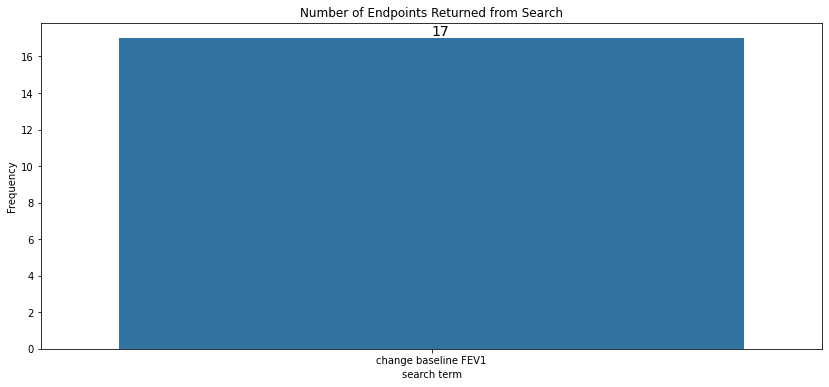

In [12]:
plot_outcome_search(search_results)

# 
I will repeat the above process using a different example - I will search for any clinical trials involving 'severe atopic dermatitis', or eczema, an inflammatory skin condition.
# 

In [13]:
atopic_derm = Query()
atopic_derm.build_query()



Enter the search query term: 

severe atopic dermatitis


Search Term: 

severe atopic dermatitis




Querying up to 1,000 trials from clinicaltrials.gov with the following url...

https://clinicaltrials.gov/api/query/study_fields?expr=severe+atopic+dermatitis&fields=NCTId%2CBriefTitle%2CCondition%2CPhase%2CStudyType%2CEnrollmentCount%2CStartDate%2CPrimaryCompletionDate%2CEligibilityCriteria%2CInterventionName%2CArmGroupInterventionName%2CArmGroupDescription%2CInterventionArmGroupLabel%2COutcomeMeasureType%2COutcomeMeasureTitle%2COutcomeMeasureDescription%2COutcomeMeasureTimeFrame%2COutcomeMeasurementValue%2COutcomeMeasureUnitOfMeasure&min_rnk=1&max_rnk=1000&fmt=json




'https://clinicaltrials.gov/api/query/study_fields?expr=severe+atopic+dermatitis&fields=NCTId%2CBriefTitle%2CCondition%2CPhase%2CStudyType%2CEnrollmentCount%2CStartDate%2CPrimaryCompletionDate%2CEligibilityCriteria%2CInterventionName%2CArmGroupInterventionName%2CArmGroupDescription%2CInterventionArmGroupLabel%2COutcomeMeasureType%2COutcomeMeasureTitle%2COutcomeMeasureDescription%2COutcomeMeasureTimeFrame%2COutcomeMeasurementValue%2COutcomeMeasureUnitOfMeasure&min_rnk=1&max_rnk=1000&fmt=json'

In [14]:
ad_study_table = atopic_derm.build_study_table(atopic_derm.get_url())
ad_study_table.head(10)

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:52: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:56: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Rank,NCTId,BriefTitle,Condition,Phase,StudyType,EnrollmentCount,StartDate,PrimaryCompletionDate,EligibilityCriteria,InterventionName,ArmGroupInterventionName,ArmGroupDescription,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure
0,13,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Moderate-to-Severe Atopic Dermatitis,Phase 3,Interventional,251,"March 21, 2017","April 4, 2018",Inclusion Criteria:\n\nMale or female ≥12 to <18 years of age at time of screening visit\nDiagno...,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]",[Participants received placebo matching dupilumab once every 2 weeks (Q2W) (including doubling t...,"[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]","[Primary, Primary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, ...",[Percentage of Participants With Investigator's Global Assessment (IGA) 0 or 1 (and Reduction Fr...,[IGA is an assessment scale used to determine severity of atopic dermatitis (AD) and clinical re...,"[Baseline and Week 16, Baseline and Week 16, Baseline and Week 16, Baseline and Week 16, Baselin...","[2.4, 17.9, 24.4, 8.2, 38.1, 41.5, -23.6, -64.8, -65.9, -19.0, -45.5, -47.9, 9.4, 38.6, 48.8, 4....","[Percentage of participants, Percentage of participants, Percent change, Percent change, Percent..."
1,14,NCT03831191,A Study of LY3375880 in Adults With Moderate-to-Severe Atopic Dermatitis,Atopic Dermatitis,Phase 2,Interventional,136,"February 12, 2019","February 27, 2020",Inclusion Criteria:\n\nParticipants must have diagnosis of AD >= 12 months according to the Amer...,"[LY3375880, Placebo]","[Drug: LY3375880, Drug: LY3375880, Drug: LY3375880, Drug: Placebo]","[Induction Period:\n\nParticipants received 50 mg LY3375880 administered SC Q4W., Induction Peri...","[150 mg LY3375880, 50 mg LY3375880, 600 mg LY3375880, Placebo]","[Primary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary]",[Percentage of Participants Achieving Validated Investigator's Global Assessment for AD (vIGA-AD...,"[vIGA-AD measures participants' overall severity of their atopic dermatitis (AD), based on a sta...","[Week 16, Week 16, Week 16, Week 16, Baseline, Week 16, Baseline, Week 16, Week 52, Induction Pe...","[9.5, 5.0, 5.9, 4.8, 19.0, 15.0, 23.5, 0.0, 4.8, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -11.45, -4.9...","[Percentage of participants, Percentage of Participants, Percentage of participants, Percentage ..."
2,15,NCT03334422,Study of Baricitinib (LY3009104) in Patients With Moderate to Severe Atopic Dermatitis,Atopic Dermatitis,Phase 3,Interventional,615,"November 27, 2017","December 12, 2018",Inclusion Criteria:\n\nHave been diagnosed with moderate to severe Atopic Dermatitis for at leas...,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Pl...",[4mg Baricitinib administered orally once daily. Placebo 1 mg and 2 mg administered orally every...,"[1mg Baricitinib, 2mg Baricitinib, 4 Milligram (mg) Baricitinib, 1mg Baricitinib, 2mg Baricitini...","[Primary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary, Secondary...",[Percentage of Participants Achieving Investigator's Global Assessment (IGA) of 0 or 1 With a ≥ ...,[The IGA measures the investigator's global assessment of the participants overall severity of t...,"[16 Weeks, 16 Weeks, 16 Weeks, 16 Weeks, Baseline, 16 Weeks, 16 Weeks, 16 Weeks, Baseline, 16 We...","[4.5, 10.6, 13.8, 4.5, 8.8, 6.1, 12.8, 17.9, 21.1, 2.5, 6.4, 8.9, 13.0, -28.91, -41.68, -54.80, ...","[percentage of participants, percentage of participants, percentage of participants, percentage ..."
3,16,NCT01785602,Efficacy and Safety Study of QAW039 in the Treatment of Patients With Moderate to Severe Atopic ...,Atopic Dermatit

In [15]:
ad_outcome_table = atopic_derm.build_outcome_table()
ad_outcome_table.shape

(652, 12)

In [16]:
tokenize_column(ad_outcome_table, 'OutcomeMeasureTitle', 'OutcomeMeasureTitleTokenized')

In [17]:
print(ad_outcome_table.shape)
ad_outcome_table.head()

(652, 13)


,NCTId,BriefTitle,Phase,InterventionName,ArmGroupInterventionName,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure,OutcomeMeasureTitleTokenized
0,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Phase 3,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]","[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]",Primary,Percentage of Participants With Investigator's Global Assessment (IGA) 0 or 1 (and Reduction Fro...,IGA is an assessment scale used to determine severity of atopic dermatitis (AD) and clinical res...,Baseline and Week 16,"[2.4, 17.9, 24.4]",Percentage of participants,"[percentage, of, participants, with, investigator's, global, assessment, iga, 0, or, 1, and, red..."
1,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Phase 3,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]","[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]",Primary,Percentage of Participants With Eczema Area and Severity Index (EASI)-75 (≥75% Improvement From ...,"The EASI score was used to measure the severity and extent of AD and measures erythema, infiltra...",Baseline and Week 16,"[8.2, 38.1, 41.5]",Percentage of participants,"[percentage, of, participants, with, eczema, area, and, severity, index, easi)-75, ≥75%, improve..."
2,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Phase 3,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]","[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]",Secondary,Percent Change From Baseline in EASI Score at Week 16,The Eczema Area and Severity Index (EASI) score was used to measure the severity and extent of A...,Baseline and Week 16,"[-23.6, -64.8, -65.9]",Percent change,"[percent, change, from, baseline, in, easi, score, at, week, 16]"
3,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Phase 3,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]","[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]",Secondary,Percent Change From Baseline in Weekly Average of Daily Peak Pruritus Numerical Rating Scale (NR...,Peak Pruritus NRS is an assessment tool used by subjects to report intensity of pruritus (itch) ...,Baseline and Week 16,"[-19.0, -45.5, -47.9]",Percent change,"[percent, change, from, baseline, in, weekly, average, of, daily, peak, pruritus, numerical, rat..."
4,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Phase 3,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]","[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]",Secondary,Percentage of Participants With Improvement (Reduction ≥3 Points) of Weekly Average of Daily Pea...,Peak Pruritus NRS is an assessment tool used by participants to report intensity of pruritus (it...,Baseline to Week 16,"[9.4, 38.6, 48.8]",Percentage of participants,"[percentage, of, participants, with, improvement, reduction, ≥3, points, of, weekly, average, of..."


In [21]:
search_results_ad = search_outcomes(ad_outcome_table, 'OutcomeMeasureTitleTokenized')
search_results_ad.head(10)

Enter your search term here: 
IGA 0 1

Searching outcomes that contain the following key terms:

['iga', '0', '1']


,index,NCTId,BriefTitle,Phase,InterventionName,ArmGroupInterventionName,InterventionArmGroupLabel,OutcomeMeasureType,OutcomeMeasureTitle,OutcomeMeasureDescription,OutcomeMeasureTimeFrame,OutcomeMeasurementValue,OutcomeMeasureUnitOfMeasure,OutcomeMeasureTitleTokenized
0,0,NCT03054428,"Efficacy and Safety of Dupilumab in Participants ≥12 to <18 Years of Age, With Moderate-to-sever...",Phase 3,"[Dupilumab, Placebo]","[Drug: Placebo, Drug: Dupilumab, Drug: Dupilumab]","[Dupilumab 200 mg or 300 mg Q2W, Dupilumab 300 mg Q4W, Placebo]",Primary,Percentage of Participants With Investigator's Global Assessment (IGA) 0 or 1 (and Reduction Fro...,IGA is an assessment scale used to determine severity of atopic dermatitis (AD) and clinical res...,Baseline and Week 16,"[2.4, 17.9, 24.4]",Percentage of participants,"[percentage, of, participants, with, investigator's, global, assessment, iga, 0, or, 1, and, red..."
1,20,NCT03334422,Study of Baricitinib (LY3009104) in Patients With Moderate to Severe Atopic Dermatitis,Phase 3,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Pl...","[1mg Baricitinib, 2mg Baricitinib, 4 Milligram (mg) Baricitinib, 1mg Baricitinib, 2mg Baricitini...",Primary,Percentage of Participants Achieving Investigator's Global Assessment (IGA) of 0 or 1 With a ≥ 2...,The IGA measures the investigator's global assessment of the participants overall severity of th...,16 Weeks,"[4.5, 10.6, 13.8, 4.5]",percentage of participants,"[percentage, of, participants, achieving, investigator's, global, assessment, iga, of, 0, or, 1,..."
2,21,NCT03334422,Study of Baricitinib (LY3009104) in Patients With Moderate to Severe Atopic Dermatitis,Phase 3,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Pl...","[1mg Baricitinib, 2mg Baricitinib, 4 Milligram (mg) Baricitinib, 1mg Baricitinib, 2mg Baricitini...",Secondary,"Percentage of Participants Achieving IGA of 0 or 1 With a ≥ 2 Point Improvement (Placebo, 1mg Ba...",The IGA measures the investigator's global assessment of the participants overall severity of th...,16 Weeks,"[8.8, 6.1, 12.8, 17.9]",percentage of participants,"[percentage, of, participants, achieving, iga, of, 0, or, 1, with, a, ≥, 2, point, improvement, ..."
3,43,NCT03334422,Study of Baricitinib (LY3009104) in Patients With Moderate to Severe Atopic Dermatitis,Phase 3,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Pl...","[1mg Baricitinib, 2mg Baricitinib, 4 Milligram (mg) Baricitinib, 1mg Baricitinib, 2mg Baricitini...",Secondary,Percentage of Participants Achieving Investigator's Global Assessment (IGA) of 0 or 1 With a ≥ 2...,The IGA measures the investigator's global assessment of the participants overall severity of th...,4 Weeks,"[-16.28, -8.94, -11.21, -23.25]",percentage of participants,"[percentage, of, participants, achieving, investigator's, global, assessment, iga, of, 0, or, 1,..."
4,44,NCT03334422,Study of Baricitinib (LY3009104) in Patients With Moderate to Severe Atopic Dermatitis,Phase 3,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Pl...","[1mg Baricitinib, 2mg Baricitinib, 4 Milligram (mg) Baricitinib, 1mg Baricitinib, 2mg Baricitini...",Primary,Percentage of Participants Achieving Investigator's Global Assessment (IGA) of 0 or 1 With a ≥ 2...,The IGA measures the investigator's global assessment of the participants overall severity of th...,16 Weeks,"[4.5, 10.6, 13.8, 4.5]",percentage of participants,"[percentage, of, participants, achieving, investigator's, global, assessment, iga, of, 0, or, 1,..."
5,45,NCT03334422,Study of Baricitinib (LY3009104) in Patients With Moderate to Severe Atopic Dermatitis,Phase 3,"[Baricitinib, Placebo]","[Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib, Drug: Placebo, Drug: Baricitinib,

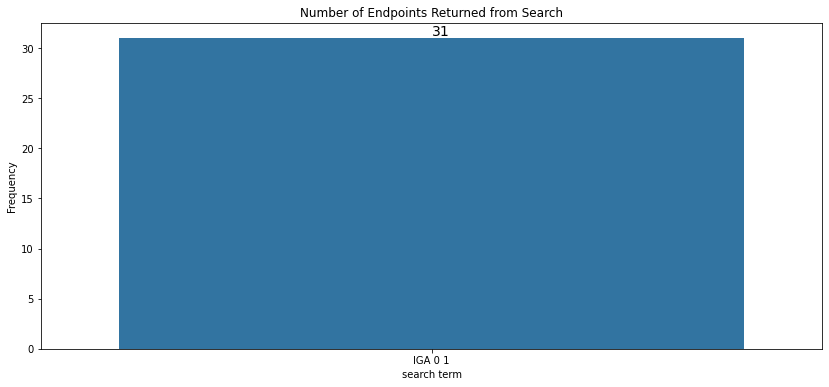

In [19]:
plot_outcome_search(search_results_ad)

For future iterations of this project, I will determine a method to reconcile endpoints that were reported inconsistently (variations in spelling / grammar / word choice, but pertaining to the same outcome measure) to be able to chart which endpoints were reported most/least frequently across the clinical trials within the Query.

The example below represents the type of functionality I intend to add to this tool in future iterations.



Enter the search query term: 

severe atopic dermatitis


Search Term: 

severe atopic dermatitis




Querying up to 1,000 trials from clinicaltrials.gov with the following url...

https://clinicaltrials.gov/api/query/study_fields?expr=severe+atopic+dermatitis&fields=NCTId%2CBriefTitle%2CCondition%2CPhase%2CStudyType%2CEnrollmentCount%2CStartDate%2CPrimaryCompletionDate%2CEligibilityCriteria%2CInterventionName%2CArmGroupInterventionName%2CArmGroupDescription%2CInterventionArmGroupLabel%2COutcomeMeasureType%2COutcomeMeasureTitle%2COutcomeMeasureDescription%2COutcomeMeasureTimeFrame%2COutcomeMeasurementValue%2COutcomeMeasureUnitOfMeasure&min_rnk=1&max_rnk=1000&fmt=json




/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:52: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:56: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


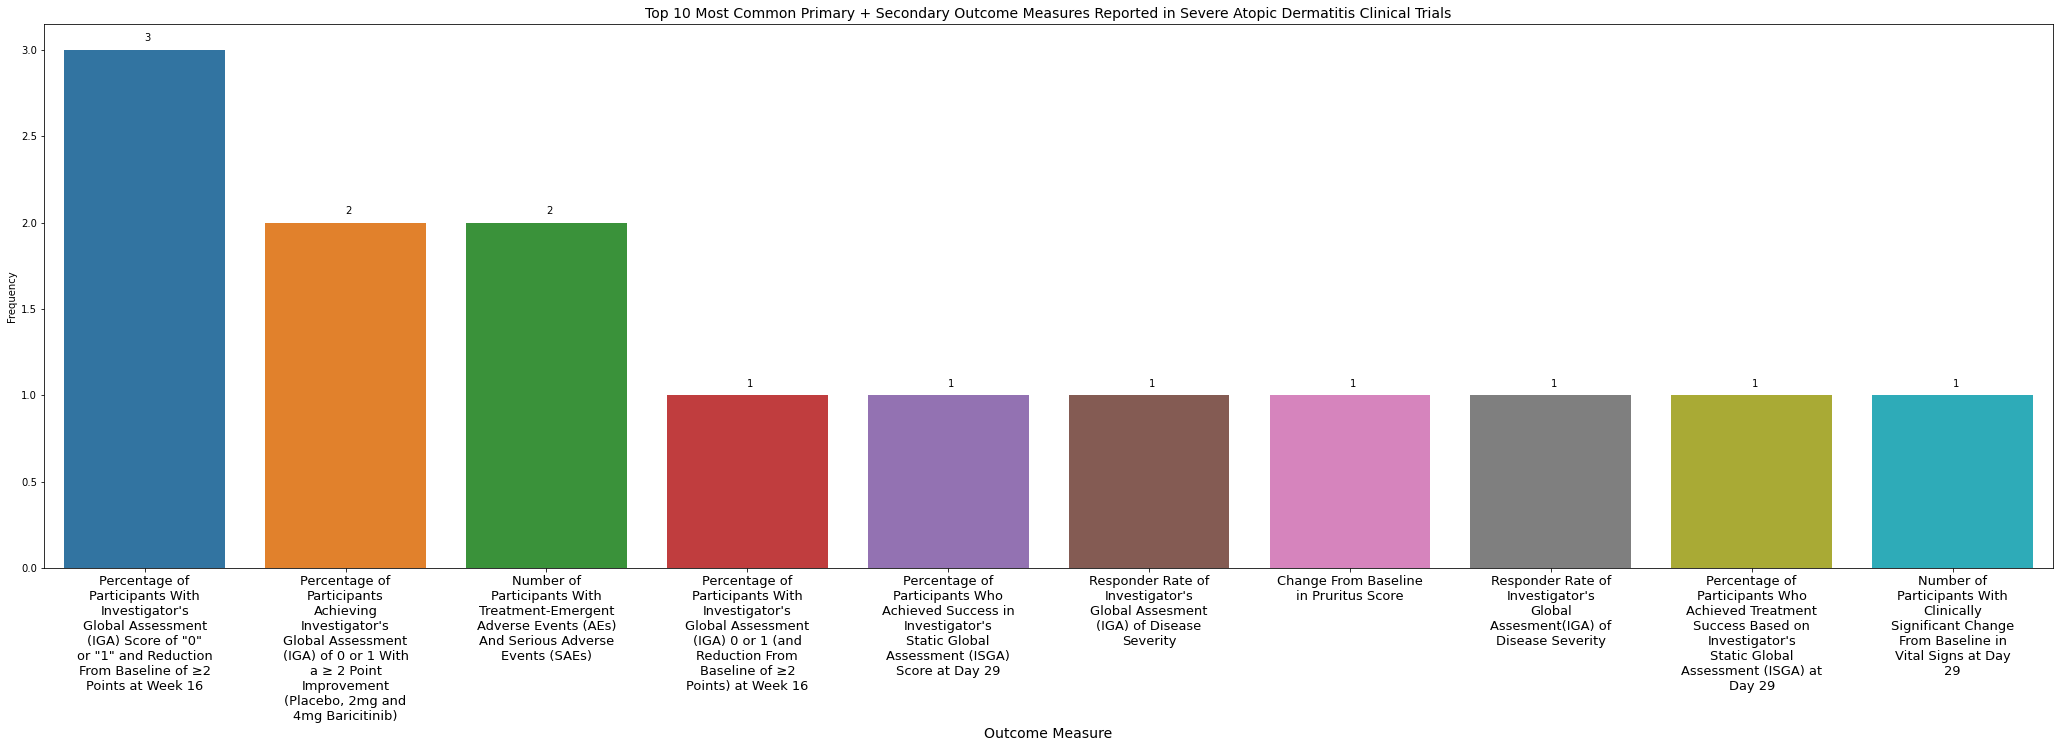

In [20]:
query1 = Query()
query1.build_query()

study_table = query1.build_study_table(query1.get_url())
outcome_table = query1.build_outcome_table()
outcome_table_primary = outcome_table[outcome_table['OutcomeMeasureType'].str.match('.*[Pp]rimary.*')]

outcome_tracker = {}
outcome_track(outcome_table_primary['OutcomeMeasureTitle'], outcome_tracker)
outcome_tracker_df = pd.Series(outcome_tracker).to_frame('Frequency').reset_index().sort_values(by='Frequency', ascending=False).reset_index().drop(columns='level_0')

plot_outcomes(outcome_tracker_df, query1)